In [ ]:
import torch
print("PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


PyTorch version: 2.6.0+cu124
Using device: cuda


**LOAD DATA**

In [ ]:
!unzip -q "/content/drive/MyDrive/AneRBC-II.zip" -d "/content/AneRBC-II"

In [ ]:
import os, glob

base_dir = "/content/AneRBC-II/AneRBC-II"

# Find all subfolders named "Original_images" one level down
original_dirs = [
    os.path.join(base_dir, d, "Original_images")
    for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d, "Original_images"))
]

print("Found these original‐image dirs:\n", "\n".join(original_dirs))


Found these original‐image dirs:
 /content/AneRBC-II/AneRBC-II/Anemic_individuals/Original_images
/content/AneRBC-II/AneRBC-II/Healthy_individuals/Original_images


In [ ]:
import random
from shutil import copy2

# 70/15/15 split ratios
splits = {"train": 0.70, "val": 0.15, "test": 0.15}
dst_root = "/content/data"

# Gather files & assign labels based on parent folder
combined = []
for orig_dir in original_dirs:
    label = "anemic" if "Anemic" in orig_dir else "healthy"
    for f in glob.glob(os.path.join(orig_dir, "*.png")):
        combined.append((f, label))

print(f"Total images found: {len(combined)}")

# Shuffle & split
random.seed(42)
random.shuffle(combined)
n = len(combined)
n_train = int(splits["train"] * n)
n_val   = int(splits["val"]   * n)

split_idxs = {
    "train": combined[:n_train],
    "val":   combined[n_train:n_train+n_val],
    "test":  combined[n_train+n_val:]
}

# Copy into data/{train,val,test}/{anemic,healthy}/
for phase, items in split_idxs.items():
    for src_path, label in items:
        dst_dir = os.path.join(dst_root, phase, label)
        os.makedirs(dst_dir, exist_ok=True)
        copy2(src_path, dst_dir)

print("Done splitting:")
print(" Train =", len(split_idxs["train"]))
print(" Val   =", len(split_idxs["val"]))
print(" Test  =", len(split_idxs["test"]))


Total images found: 12000
Done splitting:
 Train = 8400
 Val   = 1800
 Test  = 1800


**TRAINING MODEL-1->EFFICIENTNET-B0**

In [ ]:
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# 1.1) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 1.2) Paths
data_dir = "/content/data"   # root with train/, val/, test/

# 1.3) Transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

# 1.4) Datasets
train_ds = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
val_ds   = datasets.ImageFolder(os.path.join(data_dir, "val"),   transform=val_transform)
test_ds  = datasets.ImageFolder(os.path.join(data_dir, "test"),  transform=val_transform)

# 1.5) DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Classes: {train_ds.classes}")
print(f"Sizes → Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


Using device: cuda
Classes: ['anemic', 'healthy']
Sizes → Train: 8400, Val: 1800, Test: 1800


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch.nn as nn
from torchvision.models import efficientnet_b0

# 2.1) Load and adapt
model = efficientnet_b0(pretrained=True)
# Replace the classifier head for 2 classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model = model.to(device)

# 2.2) Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# (Optional) LR scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3, verbose=True
)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 47.7MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_l

In [ ]:
from tqdm import tqdm

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in tqdm(loader, desc="Train"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc

def validate(model, loader, criterion):
    model.eval()
    running_loss, running_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Val"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc

# 3.1) Train for N epochs
num_epochs = 10
best_val_acc = 0.0

for epoch in range(1, num_epochs+1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss,   val_acc   = validate(model, val_loader,   criterion)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f},   Val   Acc: {val_acc:.4f}")

    # Step scheduler (if used)
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "efficientnet_b0_best.pth")
        print("→ Saved best model\n")



Epoch 1/10


Val: 100%|██████████| 57/57 [00:09<00:00,  5.71it/s]


Train Loss: 0.3882, Train Acc: 0.8144
Val   Loss: 0.2360,   Val   Acc: 0.8806
→ Saved best model


Epoch 2/10


Val: 100%|██████████| 57/57 [00:10<00:00,  5.40it/s]


Train Loss: 0.2748, Train Acc: 0.8668
Val   Loss: 0.1976,   Val   Acc: 0.9022
→ Saved best model


Epoch 3/10


Val: 100%|██████████| 57/57 [00:09<00:00,  5.90it/s]


Train Loss: 0.2432, Train Acc: 0.8830
Val   Loss: 0.1714,   Val   Acc: 0.9283
→ Saved best model


Epoch 4/10


Val: 100%|██████████| 57/57 [00:07<00:00,  7.27it/s]


Train Loss: 0.2143, Train Acc: 0.8992
Val   Loss: 0.1734,   Val   Acc: 0.9222

Epoch 5/10


Val: 100%|██████████| 57/57 [00:09<00:00,  5.81it/s]


Train Loss: 0.1966, Train Acc: 0.9063
Val   Loss: 0.1483,   Val   Acc: 0.9300
→ Saved best model


Epoch 6/10


Val: 100%|██████████| 57/57 [00:09<00:00,  6.01it/s]


Train Loss: 0.1863, Train Acc: 0.9150
Val   Loss: 0.1247,   Val   Acc: 0.9411
→ Saved best model


Epoch 7/10


Val: 100%|██████████| 57/57 [00:07<00:00,  7.21it/s]


Train Loss: 0.1607, Train Acc: 0.9276
Val   Loss: 0.1156,   Val   Acc: 0.9461
→ Saved best model


Epoch 8/10


Val: 100%|██████████| 57/57 [00:09<00:00,  6.03it/s]


Train Loss: 0.1523, Train Acc: 0.9283
Val   Loss: 0.1124,   Val   Acc: 0.9422

Epoch 9/10


Val: 100%|██████████| 57/57 [00:09<00:00,  5.92it/s]


Train Loss: 0.1469, Train Acc: 0.9311
Val   Loss: 0.1109,   Val   Acc: 0.9472
→ Saved best model


Epoch 10/10


Val: 100%|██████████| 57/57 [00:07<00:00,  7.24it/s]

Train Loss: 0.1353, Train Acc: 0.9361
Val   Loss: 0.1487,   Val   Acc: 0.9317


**TRAINING MODEL-2->RESNET18**

In [ ]:
from torchvision import models
import torch.nn as nn

# Load ResNet18 with pretrained weights
resnet18 = models.resnet18(pretrained=True)

# Modify the final layer for binary classification
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 1)  # Output 1 logit for binary classification

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


In [ ]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
from tqdm import tqdm
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10, save_path="best_model.pth"):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        # ---- TRAINING ----
        model.train()
        running_loss, running_corrects = 0.0, 0
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())  # BCEWithLogitsLoss expects float targets

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs).squeeze().round()
            running_corrects += (preds == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # ---- VALIDATION ----
        model.eval()
        running_loss, running_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1).float())
                running_loss += loss.item() * inputs.size(0)
                preds = torch.sigmoid(outputs).squeeze().round()
                running_corrects += (preds == labels).sum().item()

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_corrects / len(val_loader.dataset)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

        if scheduler:
            scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"→ Saved best model to {save_path}")

    return model, history


In [ ]:
resnet18, history_resnet = train_model(
    model=resnet18,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=10,
    save_path="resnet18_best.pth"
)



Epoch 1/10


Validation: 100%|██████████| 57/57 [00:07<00:00,  7.42it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 0.4719, Train Acc: 0.7748
Val   Loss: 0.5262, Val   Acc: 0.7872
→ Saved best model to resnet18_best.pth

Epoch 2/10


Validation: 100%|██████████| 57/57 [00:08<00:00,  6.76it/s]


Train Loss: 0.3571, Train Acc: 0.8289
Val   Loss: 0.5740, Val   Acc: 0.7578

Epoch 3/10


Validation: 100%|██████████| 57/57 [00:09<00:00,  6.15it/s]


Train Loss: 0.3401, Train Acc: 0.8387
Val   Loss: 0.6482, Val   Acc: 0.7017

Epoch 4/10


Validation: 100%|██████████| 57/57 [00:09<00:00,  6.13it/s]


Train Loss: 0.3279, Train Acc: 0.8465
Val   Loss: 0.3515, Val   Acc: 0.8222
→ Saved best model to resnet18_best.pth

Epoch 5/10


Validation: 100%|██████████| 57/57 [00:07<00:00,  7.38it/s]


Train Loss: 0.3100, Train Acc: 0.8533
Val   Loss: 0.2795, Val   Acc: 0.8739
→ Saved best model to resnet18_best.pth

Epoch 6/10


Validation: 100%|██████████| 57/57 [00:09<00:00,  6.00it/s]


Train Loss: 0.3072, Train Acc: 0.8492
Val   Loss: 0.3274, Val   Acc: 0.8433

Epoch 7/10


Validation: 100%|██████████| 57/57 [00:09<00:00,  6.16it/s]


Train Loss: 0.2995, Train Acc: 0.8543
Val   Loss: 0.2917, Val   Acc: 0.8667

Epoch 8/10


Validation: 100%|██████████| 57/57 [00:09<00:00,  6.24it/s]


Train Loss: 0.2843, Train Acc: 0.8656
Val   Loss: 0.3000, Val   Acc: 0.8611

Epoch 9/10


Validation: 100%|██████████| 57/57 [00:07<00:00,  7.52it/s]


Train Loss: 0.2830, Train Acc: 0.8637
Val   Loss: 0.2714, Val   Acc: 0.8722

Epoch 10/10


Validation: 100%|██████████| 57/57 [00:07<00:00,  7.33it/s]

Train Loss: 0.2738, Train Acc: 0.8682
Val   Loss: 0.7294, Val   Acc: 0.7061


**TRAINING MODEL-3->DENSENET121**

In [ ]:
from torchvision import models

# Load pretrained DenseNet121
densenet = models.densenet121(pretrained=True)

# Freeze base layers (optional – can unfreeze later for fine-tuning)
for param in densenet.features.parameters():
    param.requires_grad = False

# Replace classifier head for binary classification
num_ftrs = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs, 2)  # Binary: Anemic / Healthy

# Move to GPU
densenet = densenet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 172MB/s]


In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)


In [ ]:
# Initialize history
history = {}
history['densenet'] = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

best_val_acc = 0.0
num_epochs = 10

for epoch in range(1, num_epochs+1):
    print(f"\nEpoch {epoch}/{num_epochs} [DenseNet121]")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f},   Val   Acc: {val_acc:.4f}")

    # Update history
    history['densenet']['train_loss'].append(train_loss)
    history['densenet']['train_acc'].append(train_acc)
    history['densenet']['val_loss'].append(val_loss)
    history['densenet']['val_acc'].append(val_acc)

    # Scheduler step
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "densenet121_best.pth")
        print("→ Saved best DenseNet model\n")



Epoch 1/10 [DenseNet121]


Val: 100%|██████████| 57/57 [00:09<00:00,  5.97it/s]


Train Loss: 0.1308, Train Acc: 0.9375
Val   Loss: 0.1214,   Val   Acc: 0.9411
→ Saved best DenseNet model


Epoch 2/10 [DenseNet121]


Val: 100%|██████████| 57/57 [00:08<00:00,  7.09it/s]


Train Loss: 0.1333, Train Acc: 0.9365
Val   Loss: 0.1389,   Val   Acc: 0.9383

Epoch 3/10 [DenseNet121]


Val: 100%|██████████| 57/57 [00:09<00:00,  5.99it/s]


Train Loss: 0.1285, Train Acc: 0.9408
Val   Loss: 0.1230,   Val   Acc: 0.9439
→ Saved best DenseNet model


Epoch 4/10 [DenseNet121]


Val: 100%|██████████| 57/57 [00:09<00:00,  6.19it/s]


Train Loss: 0.1266, Train Acc: 0.9419
Val   Loss: 0.1274,   Val   Acc: 0.9411

Epoch 5/10 [DenseNet121]


Val: 100%|██████████| 57/57 [00:08<00:00,  6.61it/s]


Train Loss: 0.1265, Train Acc: 0.9400
Val   Loss: 0.1325,   Val   Acc: 0.9406

Epoch 6/10 [DenseNet121]


Val: 100%|██████████| 57/57 [00:09<00:00,  6.27it/s]


Train Loss: 0.1251, Train Acc: 0.9406
Val   Loss: 0.1264,   Val   Acc: 0.9428

Epoch 7/10 [DenseNet121]


Val: 100%|██████████| 57/57 [00:08<00:00,  6.35it/s]


Train Loss: 0.1305, Train Acc: 0.9392
Val   Loss: 0.1281,   Val   Acc: 0.9400

Epoch 8/10 [DenseNet121]


Val: 100%|██████████| 57/57 [00:09<00:00,  6.06it/s]


Train Loss: 0.1294, Train Acc: 0.9383
Val   Loss: 0.1272,   Val   Acc: 0.9389

Epoch 9/10 [DenseNet121]


Val: 100%|██████████| 57/57 [00:09<00:00,  5.93it/s]


Train Loss: 0.1258, Train Acc: 0.9396
Val   Loss: 0.1240,   Val   Acc: 0.9450
→ Saved best DenseNet model


Epoch 10/10 [DenseNet121]


Val: 100%|██████████| 57/57 [00:08<00:00,  7.10it/s]

Train Loss: 0.1237, Train Acc: 0.9394
Val   Loss: 0.1398,   Val   Acc: 0.9406


In [ ]:
# Define Paths
drive_folder = "/content/drive/My Drive/SickleCellModels"
model1 = drive_folder + "/resnet18_best.pth"
model2 = drive_folder + "/efficientnet_b0_best.pth"
model3=drive_folder + "/densenet121_best.pth"

In [ ]:
import os
import shutil
os.makedirs(drive_folder, exist_ok=True)

#Save models to Google Drive
shutil.copy('/content/resnet18_best.pth', drive_folder + "/resnet18_best.pth")
shutil.copy('/content/efficientnet_b0_best.pth', drive_folder + "/efficientnet_b0_best.pth")
shutil.copy('/content/densenet121_best.pth', drive_folder + "/densenet121_best.pth")

'/content/drive/My Drive/SickleCellModels/densenet121_best.pth'

**TRAINING ON MODEL-4->CUSTOM CNN**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm import tqdm

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Image transformations (as used earlier)
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((306, 320)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((306, 320)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


Using device: cuda


In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → [32, 153, 160]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → [64, 76, 80]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → [128, 38, 40]

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)   # → [256, 19, 20]
        )

        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Sequential(
            nn.Linear(256 * 19 * 20, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)  # 2 classes: anemic, healthy
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
data_dir = "/content/data"

train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=image_transforms["train"])
val_dataset   = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=image_transforms["val"])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
model = ImprovedCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in tqdm(loader, desc="Train"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc


def validate(model, loader, criterion):
    model.eval()
    running_loss, running_corrects = 0.0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Val"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(1) == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc


In [ ]:
num_epochs = 15
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc     = validate(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f},   Val   Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "custom_cnn_best.pth")
        print("→ Saved best model\n")



Epoch 1/15


Val: 100%|██████████| 57/57 [00:11<00:00,  4.79it/s]


Train Loss: 0.7398, Train Acc: 0.5671
Val   Loss: 0.6378,   Val   Acc: 0.6217
→ Saved best model


Epoch 2/15


Val: 100%|██████████| 57/57 [00:12<00:00,  4.64it/s]


Train Loss: 0.6258, Train Acc: 0.6470
Val   Loss: 0.5481,   Val   Acc: 0.6939
→ Saved best model


Epoch 3/15


Val: 100%|██████████| 57/57 [00:10<00:00,  5.38it/s]


Train Loss: 0.5436, Train Acc: 0.7160
Val   Loss: 0.4836,   Val   Acc: 0.7644
→ Saved best model


Epoch 4/15


Val: 100%|██████████| 57/57 [00:11<00:00,  4.77it/s]


Train Loss: 0.4909, Train Acc: 0.7515
Val   Loss: 0.5495,   Val   Acc: 0.7311

Epoch 5/15


Val: 100%|██████████| 57/57 [00:11<00:00,  4.76it/s]


Train Loss: 0.4579, Train Acc: 0.7626
Val   Loss: 0.7609,   Val   Acc: 0.6206

Epoch 6/15


Val: 100%|██████████| 57/57 [00:12<00:00,  4.62it/s]


Train Loss: 0.4382, Train Acc: 0.7745
Val   Loss: 0.3400,   Val   Acc: 0.8433
→ Saved best model


Epoch 7/15


Val: 100%|██████████| 57/57 [00:10<00:00,  5.24it/s]


Train Loss: 0.4269, Train Acc: 0.7849
Val   Loss: 0.3689,   Val   Acc: 0.8228

Epoch 8/15


Val: 100%|██████████| 57/57 [00:11<00:00,  4.84it/s]


Train Loss: 0.4108, Train Acc: 0.7936
Val   Loss: 0.3518,   Val   Acc: 0.8222

Epoch 9/15


Val: 100%|██████████| 57/57 [00:11<00:00,  4.82it/s]


Train Loss: 0.4056, Train Acc: 0.7952
Val   Loss: 0.3980,   Val   Acc: 0.7900

Epoch 10/15


Val: 100%|██████████| 57/57 [00:12<00:00,  4.60it/s]


Train Loss: 0.3945, Train Acc: 0.8046
Val   Loss: 0.3079,   Val   Acc: 0.8533
→ Saved best model


Epoch 11/15


Val: 100%|██████████| 57/57 [00:12<00:00,  4.68it/s]


Train Loss: 0.3922, Train Acc: 0.7998
Val   Loss: 0.4155,   Val   Acc: 0.7828

Epoch 12/15


Val: 100%|██████████| 57/57 [00:11<00:00,  5.18it/s]


Train Loss: 0.3870, Train Acc: 0.8105
Val   Loss: 0.3469,   Val   Acc: 0.8406

Epoch 13/15


Val: 100%|██████████| 57/57 [00:11<00:00,  4.80it/s]


Train Loss: 0.3812, Train Acc: 0.8063
Val   Loss: 0.4245,   Val   Acc: 0.7706

Epoch 14/15


Val: 100%|██████████| 57/57 [00:11<00:00,  4.88it/s]


Train Loss: 0.3882, Train Acc: 0.8086
Val   Loss: 0.3172,   Val   Acc: 0.8500

Epoch 15/15


Val: 100%|██████████| 57/57 [00:11<00:00,  4.81it/s]


Train Loss: 0.3616, Train Acc: 0.8225
Val   Loss: 0.2729,   Val   Acc: 0.8744
→ Saved best model



In [ ]:
model.load_state_dict(torch.load("custom_cnn_best.pth"))
model.eval()
model4=drive_folder + "/custom_cnn_best.pth"
#Save model to Google Drive
shutil.copy('/content/custom_cnn_best.pth', drive_folder + "/custom_cnn_best.pth")


'/content/drive/My Drive/SickleCellModels/custom_cnn_best.pth'

**Comparison of models based on Training and Validation accuracy**

In [ ]:
import tabulate
import pandas as pd
from tabulate import tabulate  # optional but nice output

# Define model performance metrics
model_comparison = {
    "Model Name": ["ResNet-18", "DenseNet-121", "EfficientNet-B0", "Custom CNN"],
    "Train Accuracy": [0.85, 0.93, 0.93, 0.82],
    "Val Accuracy": [0.87, 0.94, 0.94, 0.87],
    "Val Loss": [0.27, 0.12, 0.11, 0.27],
    "Best Epoch": [5, 9, 9, 15]
}

# Create DataFrame
df = pd.DataFrame(model_comparison)

# Print using tabulate for pretty formatting (optional)
print(tabulate(df, headers='keys', tablefmt='pretty'))


+---+-----------------+----------------+--------------+----------+------------+
|   |   Model Name    | Train Accuracy | Val Accuracy | Val Loss | Best Epoch |
+---+-----------------+----------------+--------------+----------+------------+
| 0 |    ResNet-18    |      0.85      |     0.87     |   0.27   |     5      |
| 1 |  DenseNet-121   |      0.93      |     0.94     |   0.12   |     9      |
| 2 | EfficientNet-B0 |      0.93      |     0.94     |   0.11   |     9      |
| 3 |   Custom CNN    |      0.82      |     0.87     |   0.27   |     15     |
+---+-----------------+----------------+--------------+----------+------------+


**FINE TUNING(PHASE-2 of Training)**

In [ ]:
!unzip -q "/content/drive/MyDrive/SickleCellDataset.zip" -d "/content/SickleCellDataset"

In [ ]:
import os

positive_src = "/content/SickleCellDataset/Positive/Unlabelled"
negative_src = "/content/SickleCellDataset/Negative/Clear"

print("Positive path exists:", os.path.exists(positive_src))
print("Negative path exists:", os.path.exists(negative_src))

print("Sample positive files:", os.listdir(positive_src)[:5])
print("Sample negative files:", os.listdir(negative_src)[:5])


Positive path exists: True
Negative path exists: True
Sample positive files: ['170.jpg', '387.jpg', '196.jpg', '216.jpg', '34.jpg']
Sample negative files: ['34.jpg', '100.jpg', '10.jpg', '14.jpg', '120.jpg']


**CREATE DATA FOR FINE TUNING**

In [ ]:
import os
import shutil
import random
from pathlib import Path

# Source folders
positive_src = "/content/SickleCellDataset/Positive/Unlabelled"
negative_src = "/content/SickleCellDataset/Negative/Clear"

# Destination root
dst_root = "/content/SickleFineTuneData"
splits = ["train", "val"]
split_ratio = 0.8  # 80% train, 20% val

# Prepare destination dirs
for split in splits:
    for cls in ["positive", "negative"]:
        os.makedirs(os.path.join(dst_root, split, cls), exist_ok=True)

# Helper function to split and copy
def split_and_copy(src_dir, label):
    files = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(files)

    split_point = int(len(files) * split_ratio)
    train_files = files[:split_point]
    val_files = files[split_point:]

    for f in train_files:
        shutil.copy2(os.path.join(src_dir, f), os.path.join(dst_root, "train", label, f))
    for f in val_files:
        shutil.copy2(os.path.join(src_dir, f), os.path.join(dst_root, "val", label, f))

# Copy files
split_and_copy(positive_src, "positive")
split_and_copy(negative_src, "negative")

print("Files copied and organized for fine-tuning.")


Files copied and organized for fine-tuning.


**FINE TUNE RESNET18**

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os

# Paths
resnet_model_path = "/content/drive/MyDrive/SickleCellModels/resnet18_best.pth"
data_dir = "/content/SickleFineTuneData"

# Transforms for fine-tuning (match original image size used before)
fine_tune_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load datasets
image_datasets = {
    phase: datasets.ImageFolder(os.path.join(data_dir, phase), transform=fine_tune_transforms[phase])
    for phase in ["train", "val"]
}
dataloaders = {
    phase: DataLoader(image_datasets[phase], batch_size=16, shuffle=True, num_workers=2)
    for phase in ["train", "val"]
}

# Load the state_dict, but exclude the fc layer
state_dict = torch.load(resnet_model_path, map_location=device)
state_dict = {k: v for k, v in state_dict.items() if 'fc' not in k}  # Exclude fc layer
model.load_state_dict(state_dict, strict=False)  # Allow missing keys (fc layer)

# Now modify the fc layer to match your fine-tuning task (2 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# *** Move the model to the GPU ***
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
best_acc = 0.0
epochs = 10

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    for phase in ["train", "val"]:
        model.train() if phase == "train" else model.eval()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])
        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Save best model
        if phase == "val" and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_path = "/content/fine_tuned_resnet.pth"
            torch.save(model.state_dict(), best_path)
            print(f"Best model saved to {best_path} (Acc: {best_acc:.4f})")

print("\nFine-tuning complete.")



Epoch 1/10
train Loss: 0.4708 Acc: 0.7819
val Loss: 0.3677 Acc: 0.8435
Best model saved to /content/fine_tuned_resnet.pth (Acc: 0.8435)

Epoch 2/10
train Loss: 0.3598 Acc: 0.8656
val Loss: 0.2978 Acc: 0.8696
Best model saved to /content/fine_tuned_resnet.pth (Acc: 0.8696)

Epoch 3/10
train Loss: 0.3067 Acc: 0.8789
val Loss: 0.2737 Acc: 0.8957
Best model saved to /content/fine_tuned_resnet.pth (Acc: 0.8957)

Epoch 4/10
train Loss: 0.2751 Acc: 0.8899
val Loss: 0.2652 Acc: 0.8957

Epoch 5/10
train Loss: 0.2338 Acc: 0.9185
val Loss: 0.2343 Acc: 0.8783

Epoch 6/10
train Loss: 0.2216 Acc: 0.9207
val Loss: 0.2088 Acc: 0.9391
Best model saved to /content/fine_tuned_resnet.pth (Acc: 0.9391)

Epoch 7/10
train Loss: 0.2420 Acc: 0.9119
val Loss: 0.2452 Acc: 0.9130

Epoch 8/10
train Loss: 0.2328 Acc: 0.9273
val Loss: 0.2223 Acc: 0.8870

Epoch 9/10
train Loss: 0.1894 Acc: 0.9361
val Loss: 0.2092 Acc: 0.9217

Epoch 10/10
train Loss: 0.1751 Acc: 0.9361
val Loss: 0.2087 Acc: 0.9304

Fine-tuning comple

In [ ]:
drive_folder = "/content/drive/My Drive/SickleCellModels"
model1 = drive_folder + "/fine_tuned_resnet.pth"
import os
import shutil
os.makedirs(drive_folder, exist_ok=True)

#Save models to Google Drive
shutil.copy('/content/fine_tuned_resnet.pth', drive_folder + "/fine_tuned_resnet.pth")

'/content/drive/My Drive/SickleCellModels/fine_tuned_resnet.pth'

**CREATE DATA FOR TESTING RESNET18**

In [ ]:
import os
import random
import shutil
from pathlib import Path

# Original source folders
positive_src = "/content/SickleCellDataset/Positive/Unlabelled"
negative_src = "/content/SickleCellDataset/Negative/Clear"

# Destination test folders
test_pos_dst = "/content/SickleFineTuneData/test/positive"
test_neg_dst = "/content/SickleFineTuneData/test/negative"

# Create dirs
os.makedirs(test_pos_dst, exist_ok=True)
os.makedirs(test_neg_dst, exist_ok=True)

# Split ratio
split_ratio = 0.2

# Copy function
def split_and_copy(src_dir, dst_dir, split_ratio):
    all_files = [f for f in os.listdir(src_dir) if f.endswith(('.png', '.jpg'))]
    random.shuffle(all_files)
    test_count = int(len(all_files) * split_ratio)
    test_files = all_files[:test_count]

    for f in test_files:
        src_path = os.path.join(src_dir, f)
        dst_path = os.path.join(dst_dir, f)
        shutil.copy2(src_path, dst_path)

    print(f"Copied {len(test_files)} images to {dst_dir}")

# Do the copying
split_and_copy(positive_src, test_pos_dst, split_ratio)
split_and_copy(negative_src, test_neg_dst, split_ratio)


Copied 84 images to /content/SickleFineTuneData/test/positive
Copied 29 images to /content/SickleFineTuneData/test/negative


**TESTING AND REPORT**

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Classification Report:

              precision    recall  f1-score   support

    negative       0.81      0.86      0.83        29
    positive       0.95      0.93      0.94        84

    accuracy                           0.91       113
   macro avg       0.88      0.90      0.89       113
weighted avg       0.91      0.91      0.91       113



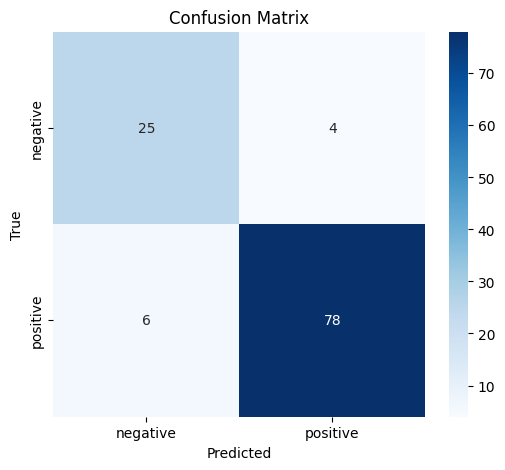

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Paths
test_dir = "/content/SickleFineTuneData/test"
model_path = "/content/fine_tuned_resnet.pth"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms (same as validation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load the model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Inference
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


**FINE TUNE DENSENET121**

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os

# Path to your saved DenseNet model
densenet_model_path = "/content/drive/MyDrive/SickleCellModels/densenet121_best.pth"
data_dir = "/content/SickleFineTuneData"

# Transforms
fine_tune_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Dataset & loaders
image_datasets = {
    phase: datasets.ImageFolder(os.path.join(data_dir, phase), transform=fine_tune_transforms[phase])
    for phase in ["train", "val"]
}
dataloaders = {
    phase: DataLoader(image_datasets[phase], batch_size=16, shuffle=True, num_workers=2)
    for phase in ["train", "val"]
}

# Load and modify DenseNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(pretrained=False) # Create a fresh densenet121 model
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 2)
# Load weights trained with densenet121
# model.load_state_dict(torch.load(densenet_model_path, map_location=device))
model = model.to(device)

# Instead of loading the full state_dict, you need to load only the classifier head's weights.
# For example:
pretrained_dict = torch.load(densenet_model_path, map_location=device)
classifier_dict = {k: v for k, v in pretrained_dict.items() if 'classifier' in k}
model.load_state_dict(classifier_dict, strict=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Fine-tuning loop
best_acc = 0.0
epochs = 10

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    for phase in ["train", "val"]:
        model.train() if phase == "train" else model.eval()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])
        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Save best model
        if phase == "val" and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_path = "/content/fine_tuned_densenet.pth"
            torch.save(model.state_dict(), best_path)
            print(f"Best model saved to {best_path} (Acc: {best_acc:.4f})")

print("\nDenseNet fine-tuning complete.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Epoch 1/10
train Loss: 0.5822 Acc: 0.7048
val Loss: 0.5080 Acc: 0.7565
Best model saved to /content/fine_tuned_densenet.pth (Acc: 0.7565)

Epoch 2/10
train Loss: 0.4914 Acc: 0.7775
val Loss: 0.4850 Acc: 0.7304

Epoch 3/10
train Loss: 0.4121 Acc: 0.8194
val Loss: 0.7745 Acc: 0.6783

Epoch 4/10
train Loss: 0.4409 Acc: 0.8172
val Loss: 0.3644 Acc: 0.8174
Best model saved to /content/fine_tuned_densenet.pth (Acc: 0.8174)

Epoch 5/10
train Loss: 0.3411 Acc: 0.8502
val Loss: 0.3160 Acc: 0.8609
Best model saved to /content/fine_tuned_densenet.pth (Acc: 0.8609)

Epoch 6/10
train Loss: 0.3662 Acc: 0.8304
val Loss: 0.3558 Acc: 0.7826

Epoch 7/10
train Loss: 0.3229 Acc: 0.8634
val Loss: 0.3581 Acc: 0.8609

Epoch 8/10
train Loss: 0.3491 Acc: 0.8370
val Loss: 0.3602 Acc: 0.8261

Epoch 9/10
train Loss: 0.3400 Acc: 0.8392
val Loss: 0.3691 Acc: 0.8261

Epoch 10/10
train Loss: 0.3348 Acc: 0.8546
val Loss: 0.3090 Acc: 0.9043
Best model saved to /content/fine_tuned_densenet.pth (Acc: 0.9043)

DenseNet f

**TESTING DENSENET121 AND REPORTS**


Classification Report:

              precision    recall  f1-score   support

    negative       0.79      0.79      0.79        29
    positive       0.93      0.93      0.93        84

    accuracy                           0.89       113
   macro avg       0.86      0.86      0.86       113
weighted avg       0.89      0.89      0.89       113



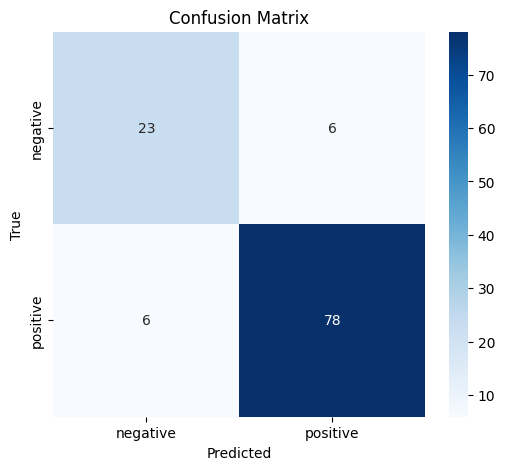

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Paths
test_dir = "/content/SickleFineTuneData/test"
model_path = "/content/fine_tuned_densenet.pth"

# Transforms (same as val)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset and DataLoader
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(pretrained=False)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Inference
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Evaluation
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


**FINE TUNE EFFICIENTNET**

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0
import os

# Paths
efficientnet_model_path = "/content/drive/MyDrive/SickleCellModels/efficientnet_b0_best.pth"
data_dir = "/content/SickleFineTuneData"

# Transforms
fine_tune_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load datasets
image_datasets = {
    phase: datasets.ImageFolder(os.path.join(data_dir, phase), transform=fine_tune_transforms[phase])
    for phase in ["train", "val"]
}
dataloaders = {
    phase: DataLoader(image_datasets[phase], batch_size=16, shuffle=True, num_workers=2)
    for phase in ["train", "val"]
}

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = efficientnet_b0(pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load(efficientnet_model_path, map_location=device))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Fine-tune
best_acc = 0.0
epochs = 10

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    for phase in ["train", "val"]:
        model.train() if phase == "train" else model.eval()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])
        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        if phase == "val" and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_path = "/content/fine_tuned_efficientnet.pth"
            torch.save(model.state_dict(), best_path)
            print(f"Best model saved to {best_path} (Acc: {best_acc:.4f})")

print("\nEfficientNet fine-tuning complete.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Epoch 1/10
train Loss: 0.9504 Acc: 0.6828
val Loss: 0.3607 Acc: 0.8696
Best model saved to /content/fine_tuned_efficientnet.pth (Acc: 0.8696)

Epoch 2/10
train Loss: 0.3347 Acc: 0.8656
val Loss: 0.3001 Acc: 0.8783
Best model saved to /content/fine_tuned_efficientnet.pth (Acc: 0.8783)

Epoch 3/10
train Loss: 0.2141 Acc: 0.9361
val Loss: 0.2715 Acc: 0.9043
Best model saved to /content/fine_tuned_efficientnet.pth (Acc: 0.9043)

Epoch 4/10
train Loss: 0.2199 Acc: 0.9317
val Loss: 0.2626 Acc: 0.9130
Best model saved to /content/fine_tuned_efficientnet.pth (Acc: 0.9130)

Epoch 5/10
train Loss: 0.1540 Acc: 0.9515
val Loss: 0.2357 Acc: 0.9043

Epoch 6/10
train Loss: 0.1305 Acc: 0.9537
val Loss: 0.2256 Acc: 0.9130

Epoch 7/10
train Loss: 0.1304 Acc: 0.9537
val Loss: 0.2133 Acc: 0.8957

Epoch 8/10
train Loss: 0.1197 Acc: 0.9515
val Loss: 0.1857 Acc: 0.9130

Epoch 9/10
train Loss: 0.0819 Acc: 0.9692
val Loss: 0.1871 Acc: 0.9130

Epoch 10/10
train Loss: 0.0724 Acc: 0.9780
val Loss: 0.1847 Acc: 0.

**TESTING EFFICIENTNET AND REPORTS**


🔍 Classification Report:
              precision    recall  f1-score   support

    negative       0.97      1.00      0.98        29
    positive       1.00      0.99      0.99        84

    accuracy                           0.99       113
   macro avg       0.98      0.99      0.99       113
weighted avg       0.99      0.99      0.99       113



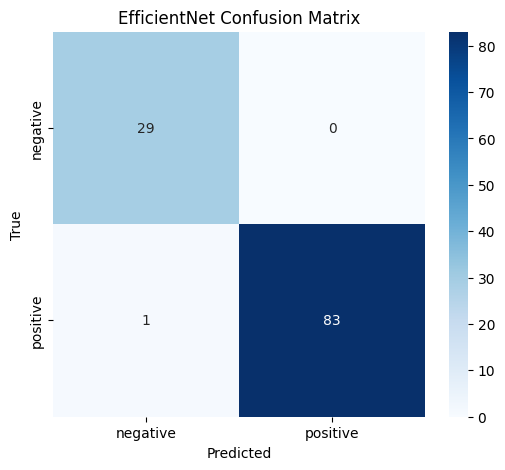

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
test_dir = "/content/SickleFineTuneData/test"
model_path = "/content/fine_tuned_efficientnet.pth"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms (same as val)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset and DataLoader
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load model
model = models.efficientnet_b0(pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Evaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
print("\n🔍 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("EfficientNet Confusion Matrix")
plt.show()


**SAVE THE FINE TUNE MODELS IN DRIVE**

In [ ]:
drive_folder = "/content/drive/My Drive/SickleCellModels"
model2 = drive_folder + "/fine_tuned_densenet.pth"
model3 = drive_folder + "/fine_tuned_efficientnet.pth"
import os
import shutil
os.makedirs(drive_folder, exist_ok=True)

#Save models to Google Drive
shutil.copy('/content/fine_tuned_densenet.pth', drive_folder + "/fine_tuned_densenet.pth")
shutil.copy('/content/fine_tuned_efficientnet.pth', drive_folder + "/fine_tuned_efficientnet.pth")

'/content/drive/My Drive/SickleCellModels/fine_tuned_efficientnet.pth'

**FINE TUNE CUSTOM CNN**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Image transformations (as used earlier)
fine_tune_transforms = {
    "train": transforms.Compose([
        transforms.Resize((306, 320)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((306, 320)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load your saved custom CNN model
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Sequential(
            nn.Linear(256 * 19 * 20, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Load datasets
data_dir = "/content/SickleFineTuneData"  # Path to your fine-tuning data
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=fine_tune_transforms["train"])
val_dataset   = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=fine_tune_transforms["val"])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in tqdm(loader, desc="Train"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc
def validate(model, loader, criterion):
    model.eval()
    running_loss, running_corrects = 0.0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Val"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(1) == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc

# Initialize the custom CNN model and load the weights if necessary
model = ImprovedCNN().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/SickleCellModels/custom_cnn_best.pth", map_location=device))

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Fine-tuning loop
num_epochs = 10
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc     = validate(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f},   Val   Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/fine_tuned_custom_cnn.pth")
        print("→ Saved best model\n")

print("\nFine-tuning complete.")


Using device: cuda

Epoch 1/10


Val: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Train Loss: 0.8343, Train Acc: 0.5793
Val   Loss: 0.5590,   Val   Acc: 0.7304
→ Saved best model


Epoch 2/10


Val: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Train Loss: 0.5943, Train Acc: 0.6916
Val   Loss: 0.5867,   Val   Acc: 0.7826
→ Saved best model


Epoch 3/10


Val: 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


Train Loss: 0.5449, Train Acc: 0.7269
Val   Loss: 0.5219,   Val   Acc: 0.7652

Epoch 4/10


Val: 100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


Train Loss: 0.5474, Train Acc: 0.7225
Val   Loss: 0.5177,   Val   Acc: 0.8087
→ Saved best model


Epoch 5/10


Val: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Train Loss: 0.5354, Train Acc: 0.6982
Val   Loss: 0.5159,   Val   Acc: 0.8087

Epoch 6/10


Val: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Train Loss: 0.5039, Train Acc: 0.7379
Val   Loss: 0.5285,   Val   Acc: 0.7652

Epoch 7/10


Val: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Train Loss: 0.5027, Train Acc: 0.7401
Val   Loss: 0.4709,   Val   Acc: 0.8087

Epoch 8/10


Val: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Train Loss: 0.4576, Train Acc: 0.7841
Val   Loss: 0.4361,   Val   Acc: 0.8087

Epoch 9/10


Val: 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Train Loss: 0.4641, Train Acc: 0.7907
Val   Loss: 0.6060,   Val   Acc: 0.7304

Epoch 10/10


Val: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

Train Loss: 0.4609, Train Acc: 0.8238
Val   Loss: 0.4917,   Val   Acc: 0.8087

Fine-tuning complete.


**SAVE FINE TUNE CNN**

In [ ]:
model4 = drive_folder + "/fine_tuned_custom_cnn.pth"
import os
import shutil
os.makedirs(drive_folder, exist_ok=True)

#Save models to Google Drive
shutil.copy('/content/fine_tuned_custom_cnn.pth', drive_folder + "/fine_tuned_custom_cnn.pth")

'/content/drive/My Drive/SickleCellModels/fine_tuned_custom_cnn.pth'

**TESTING AND REPORTS**

Using device: cuda


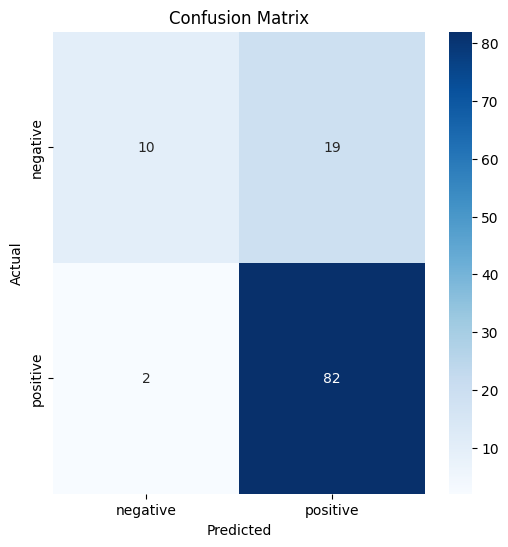

Test Accuracy: 81.42%

Classification Report:

              precision    recall  f1-score   support

    negative       0.83      0.34      0.49        29
    positive       0.81      0.98      0.89        84

    accuracy                           0.81       113
   macro avg       0.82      0.66      0.69       113
weighted avg       0.82      0.81      0.78       113



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Image transformations for testing
test_transforms = transforms.Compose([
    transforms.Resize((306, 320)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load the test dataset
test_dir = "/content/SickleFineTuneData/test"  # Ensure you have a test folder
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load your fine-tuned model
model = ImprovedCNN().to(device)
model.load_state_dict(torch.load("/content/fine_tuned_custom_cnn.pth", map_location=device))
model.eval()

# Testing loop
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Calculate accuracy
accuracy = sum([cm[i, i] for i in range(len(test_dataset.classes))]) / cm.sum()
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification Report
report = classification_report(all_labels, all_preds, target_names=test_dataset.classes)
print("\nClassification Report:\n")
print(report)


**MODEL COMPARISON based on Testing Accuracy**


Model Comparison Summary:

       Model  Test Accuracy (%) Precision (Neg / Pos) Recall (Neg / Pos) F1-Score (Neg / Pos)
    ResNet50                 91           0.81 / 0.95        0.86 / 0.93          0.83 / 0.94
 DenseNet121                 89           0.79 / 0.93        0.79 / 0.93          0.79 / 0.93
EfficientNet                 99           0.97 / 1.00        1.00 / 0.99          0.98 / 0.99
  Custom CNN                 81           0.83 / 0.81        0.34 / 0.98          0.49 / 0.89

Summary saved to 'model_comparison_summary.csv'


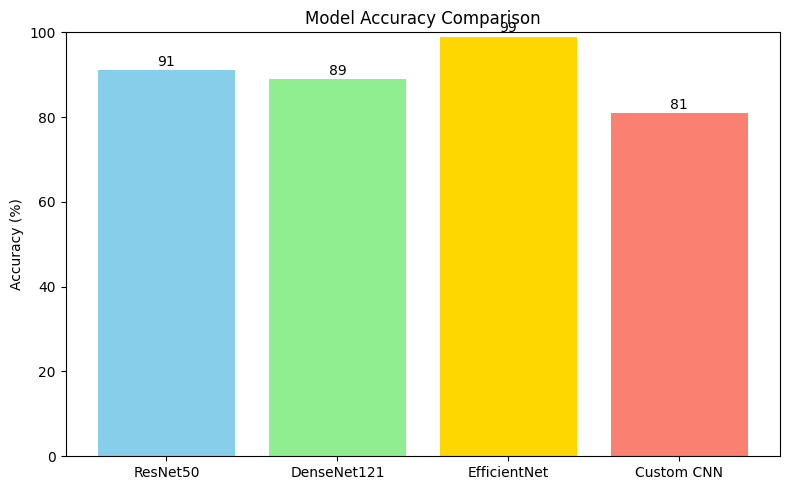

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define metrics for each model
data = {
    "Model": ["ResNet50", "DenseNet121", "EfficientNet", "Custom CNN"],
    "Test Accuracy (%)": [91, 89, 99, 81],
    "Precision (Neg / Pos)": ["0.81 / 0.95", "0.79 / 0.93", "0.97 / 1.00", "0.83 / 0.81"],
    "Recall (Neg / Pos)": ["0.86 / 0.93", "0.79 / 0.93", "1.00 / 0.99", "0.34 / 0.98"],
    "F1-Score (Neg / Pos)": ["0.83 / 0.94", "0.79 / 0.93", "0.98 / 0.99", "0.49 / 0.89"]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the table
print("\nModel Comparison Summary:\n")
print(df.to_string(index=False))

# Save to CSV
df.to_csv("model_comparison_summary.csv", index=False)
print("\nSummary saved to 'model_comparison_summary.csv'")

# Optional: Bar plot of accuracy comparison
plt.figure(figsize=(8, 5))
plt.bar(df["Model"], df["Test Accuracy (%)"], color=['skyblue', 'lightgreen', 'gold', 'salmon'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
for index, value in enumerate(df["Test Accuracy (%)"]):
    plt.text(index, value + 1, str(value), ha='center')
plt.tight_layout()
plt.savefig("accuracy_comparison_plot.png")
plt.show()


**TESTING ON USER INPUT IMAGE**

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# ----- Set device -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Preprocessing per model type -----
def get_transform(model_type):
    if model_type in ["resnet", "densenet", "efficientnet"]:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    elif model_type == "custom":
        return transforms.Compose([
            transforms.Resize((306, 320)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    else:
        raise ValueError("Unknown model type")

# ----- Load Image -----
def preprocess_image(image_path, model_type):
    transform = get_transform(model_type)
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor.to(device)

# ----- Load Model -----
def load_model(model_type, model_path):
    if model_type == "resnet":
        from torchvision.models import resnet18
        model = resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, 2)

    elif model_type == "densenet":
        from torchvision.models import densenet121
        model = densenet121(pretrained=False)
        model.classifier = nn.Linear(model.classifier.in_features, 2)

    elif model_type == "efficientnet":
        from torchvision.models import efficientnet_b0
        model = efficientnet_b0(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

    elif model_type == "custom":
        class ImprovedCNN(nn.Module):
            def __init__(self):
                super(ImprovedCNN, self).__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=3, padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(32, 64, kernel_size=3, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(64, 128, kernel_size=3, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(128, 256, kernel_size=3, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
                    nn.MaxPool2d(2)
                )
                self.dropout = nn.Dropout(0.5)
                self.classifier = nn.Sequential(
                    nn.Linear(256 * 19 * 20, 256),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(256, 2)
                )

            def forward(self, x):
                x = self.features(x)
                x = x.view(x.size(0), -1)
                x = self.classifier(x)
                return x

        model = ImprovedCNN()

    else:
        raise ValueError("Unsupported model type")

    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

# ----- Predict -----
def predict(image_path, model_type, model_path):
    model = load_model(model_type, model_path)
    image_tensor = preprocess_image(image_path, model_type)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    label = "Healthy" if predicted.item() == 0 else "Sickle (Anemic)"
    print(f"Predicted Label: {label}")
    return label

# ----- Example usage -----
image_path = "/content/1.jpg"
model_type = "custom" #"resnet"  # or "densenet", "efficientnet", "custom"
model_path = "/content/fine_tuned_custom_cnn.pth"
predict(image_path, model_type, model_path)


Predicted Label: Healthy


'Healthy'

In [1]:
import tabulate
import pandas as pd
from tabulate import tabulate  # optional but nice output

# Define model performance metrics
model_comparison = {
    "Model Name": ["SVM", "MLP", "Logistic Regression", "KNN"],
    "Train Accuracy": [0.96, 0.91, 0.90, 0.86],
    "Precision": [0.92, 0.91, 0.90, 0.87],
    "Recall": [0.97, 0.87, 0.86, 0.86],
    "F1-Score": [0.96, 0.91, 0.90, 0.86]
}

# Create DataFrame
df = pd.DataFrame(model_comparison)

# Print using tabulate for pretty formatting (optional)
print(tabulate(df, headers='keys', tablefmt='pretty'))


+---+---------------------+----------------+-----------+--------+----------+
|   |     Model Name      | Train Accuracy | Precision | Recall | F1-Score |
+---+---------------------+----------------+-----------+--------+----------+
| 0 |         SVM         |      0.96      |   0.92    |  0.97  |   0.96   |
| 1 |         MLP         |      0.91      |   0.91    |  0.87  |   0.91   |
| 2 | Logistic Regression |      0.9       |    0.9    |  0.86  |   0.9    |
| 3 |         KNN         |      0.86      |   0.87    |  0.86  |   0.86   |
+---+---------------------+----------------+-----------+--------+----------+
